# CONSTANTS

In [2]:
import CONSTANTS as c

NR_OF_BINS = c.NR_OF_BINS
BACKWARD_WINDOW_LENGTH = 3 #c.BACKWARD_WINDOW_LENGTH
FORWARD_WINDOW_LENGTH = 1 #c.FORWARD_WINDOW_LENGTH
INTERPLOATION_POINTS = c.INTERPLOATION_POINTS
EXCHANGE_RATES = c.EXCHANGE_RATES

FROM_TIMESTAMP = '2022-09-01 00:00' # c.FROM_TIMESTAMP
TO_TIMESTAMP = c.TO_TIMESTAMP
FFT_AC_COEFFICIENT  = c.FFT_AC_COEFFICIENT
LOWER_POINT = c.LOWER_POINT
UPPER_POINT = c.UPPER_POINT
THRESHOLD = c.THRESHOLD

# LIBRARIES

In [3]:
import pandas as pd

import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

from scipy.stats import ks_2samp
from scipy import interpolate
from numpy.fft import fft,ifft

import tensorflow as tf

from sklearn.preprocessing import  KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# DATA SOURCE

In [4]:
X_ORIGINAL = np.load(r'Temp\X_ORIGINAL.npy')
Y_ORIGINAL = np.load(r'Temp\Y_ORIGINAL.npy')
X_TIME_ORIGINAL = np.load(r'Temp\X_TIME_ORIGINAL.npy')

# PREPROCESS

In [125]:
# build a pattern example (only for test purpose later read from a file that contains the patterns
NR_OF_PATTERNS = 4
aPatterns = np.zeros((NR_OF_PATTERNS, FORWARD_WINDOW_LENGTH, NR_OF_BINS))
aPatterns[0, 0,2:5 ] = 1
aPatterns[1, 0,1:6 ] = 1
aPatterns[2, 0,4:6 ] = 1
aPatterns[3, 0,3:5 ] = 1
aPatterns

array([[[0., 0., 1., 1., 1., 0., 0., 0., 0., 0.]],

       [[0., 1., 1., 1., 1., 1., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 1., 1., 0., 0., 0., 0.]],

       [[0., 0., 0., 1., 1., 0., 0., 0., 0., 0.]]])

In [139]:
######################################################## COMPILE INPUT DATASET (S) ########################################################
# reduce dimension of input dataset with fast fourier transform
X = np.zeros((X_ORIGINAL.shape[0], X_ORIGINAL.shape[1], FFT_AC_COEFFICIENT, X_ORIGINAL.shape[3]))
for i in range(X_ORIGINAL.shape[1]): #future time step
    for j in range(X_ORIGINAL.shape[3]): #exchange rate
        aTransformed = fft(X_ORIGINAL[:, i,:,j])
        aTransformed = aTransformed[:, :FFT_AC_COEFFICIENT]
        aInverseTransformed = ifft(aTransformed)
        X[:, i,:,j] = aInverseTransformed
        
X_TIME = X_TIME_ORIGINAL.copy()
        
######################################################## COMPILE OUTPUT DATASET ########################################################
Y= Y_ORIGINAL.copy()
Y[Y<LOWER_POINT] = LOWER_POINT
Y[Y>UPPER_POINT] = UPPER_POINT


# interplating Y dataset (as data augmentation ?)
Y_copy = Y.copy()
Y = np.zeros((Y_copy.shape[0], Y_copy.shape[1], INTERPLOATION_POINTS, Y_copy.shape[3]))
for i in range(Y_copy.shape[1]): #future time step
    for j in range(Y_copy.shape[3]): #exchange rate
        aX = list(range(0,60))
        aY = Y_copy[:, i,:,j]

        oInterpolate = interpolate.interp1d(aX, aY, kind = 'linear')

        aX_new = np.linspace(0, 59, INTERPLOATION_POINTS)
        aY_new = oInterpolate(aX_new)
        
        Y[:, i,:,j] = aY_new
        

        
# discritize output to histogram bin size
aHistogramBins = np.linspace(LOWER_POINT,UPPER_POINT, num = INTERPLOATION_POINTS).reshape(-1 ,1)
oOutputDiscritizer = KBinsDiscretizer(n_bins = NR_OF_BINS, encode = 'ordinal', strategy = 'uniform')
aBins = oOutputDiscritizer.fit_transform(aHistogramBins).astype(int)
Y = oOutputDiscritizer.transform(Y.reshape(-1,1)).reshape(Y.shape).astype(int)


# calculate frequencies
Y_copy = Y.copy()
Y = np.zeros((Y_copy.shape[0], Y_copy.shape[1], NR_OF_BINS, Y_copy.shape[3]))
for i in range(Y_copy.shape[1]): #future time step
    for j in range(Y_copy.shape[3]): #exchange rate
        aOriginal = Y_copy[:, i,:,j]
        df = pd.DataFrame(aOriginal).melt(ignore_index = False)
        df.reset_index(inplace = True)
        df = pd.pivot_table(df , columns = 'value', index = 'index', values = 'variable', aggfunc='count', fill_value=0)
        Y[:, i,:,j] = df.values

# convert to softmax format
Y = Y/INTERPLOATION_POINTS

# set the active values to 1
Y[Y>=THRESHOLD] = 1
Y[Y<THRESHOLD] = 0

# identify the patterns



Y_copy = Y.copy()
Y = np.zeros((Y_copy.shape[0], NR_OF_PATTERNS, Y_copy.shape[3]))

for i in range(NR_OF_PATTERNS):
    for j in range(Y_copy.shape[3]):
        aPattern = aPatterns[i]
        ixConditionsMet = np.where((Y_copy[:,:,:,j] == aPattern).all(axis = 2))[0]
        Y[ixConditionsMet, i]  = 1



######################################################## SPLIT DATASETS ########################################################
c_fTrainingRatio = 0.70
c_fValidationRatio = 0.28
c_fTestRatio = 0.02

X_train,X_test, Y_train, Y_test, X_TIME_train, X_TIME_test = train_test_split(
    X,Y,X_TIME,
    test_size=1-c_fTrainingRatio,
    shuffle=False,
    random_state = 1
)

X_validation, X_test,Y_validation, Y_test, X_TIME_validation, X_TIME_test = train_test_split(
    X_test,Y_test,X_TIME_test,
    test_size=c_fTestRatio/(c_fTestRatio + c_fValidationRatio),
    shuffle=False,
    random_state = 1
)


X_train = X_train[:,:,:,0]
X_validation = X_validation[:,:,:,0]
X_test = X_test[:,:,:,0]

Y_train = Y_train[:,:,0]
Y_validation = Y_validation[:,:,0]
Y_test = Y_test[:,:,0]

C:\Users\yunus\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


# ANALYZE

41/41 [==============================] - 1s 20ms/step - loss: 0.2187 - auc_3: 0.9022
Epoch 324/1000
41/41 [==============================] - 1s 20ms/step - loss: 0.2190 - auc_3: 0.9018
Epoch 325/1000
41/41 [==============================] - 1s 18ms/step - loss: 0.2191 - auc_3: 0.9017
Epoch 326/1000
41/41 [==============================] - 1s 19ms/step - loss: 0.2190 - auc_3: 0.9016
Epoch 327/1000
41/41 [==============================] - 1s 19ms/step - loss: 0.2193 - auc_3: 0.9012
Epoch 328/1000
41/41 [==============================] - 1s 18ms/step - loss: 0.2184 - auc_3: 0.9025
Epoch 329/1000
41/41 [==============================] - 1s 19ms/step - loss: 0.2192 - auc_3: 0.9016
Epoch 330/1000
41/41 [==============================] - 1s 19ms/step - loss: 0.2190 - auc_3: 0.9018
Epoch 331/1000
41/41 [==============================] - 1s 20ms/step - loss: 0.2194 - auc_3: 0.9015
Epoch 332/1000
41/41 [==============================] - 1s 20ms/step - loss: 0.2188 - auc_3: 0.9021
Epoch 333/1000


KeyError: 'val_loss'

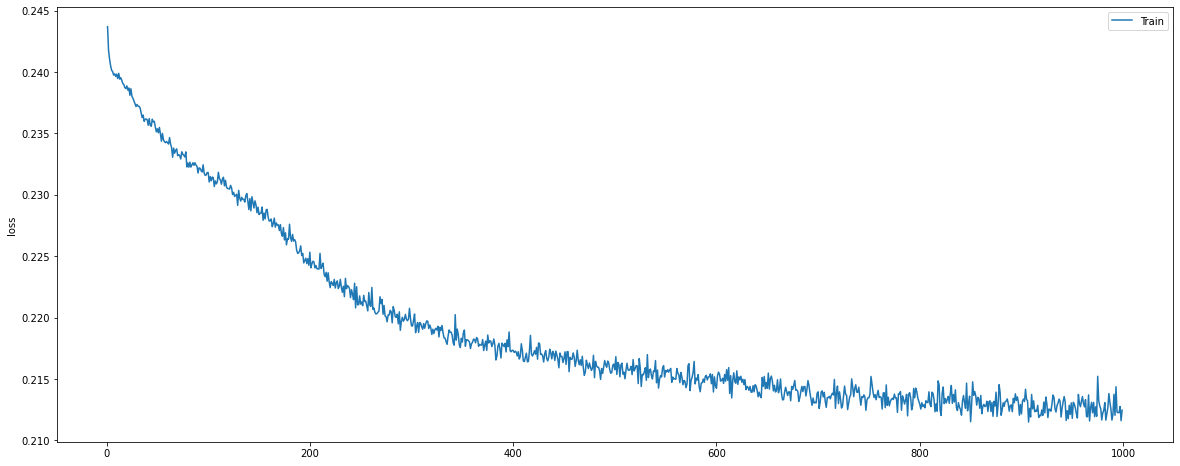

In [183]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

class Time2Vec(Layer):
    def __init__(self, kernel_size, periodic_activation='sin'):
        '''
        :param kernel_size:         The length of time vector representation.
        :param periodic_activation: The periodic activation, sine or cosine, or any future function.
        '''
        super(Time2Vec, self).__init__(
            trainable=True,
            name='Time2VecLayer_'+periodic_activation.upper()
        )
        
        self.k = kernel_size
        self.p_activation = periodic_activation
    
    def build(self, input_shape):
        # While i = 0
        self.wb = self.add_weight(
            shape=(1, 1),
            initializer='uniform',
            trainable=True
        )
        
        self.bb = self.add_weight(
            shape=(1, 1),
            initializer='uniform',
            trainable=True
        )
        
        # Else needs to pass the periodic activation
        self.wa = self.add_weight(
            shape=(1, self.k),
            initializer='uniform',
            trainable=True
        )
        
        self.ba = self.add_weight(
            shape=(1, self.k),
            initializer='uniform',
            trainable=True
        )
        
        super(Time2Vec, self).build(input_shape)
    
    def call(self, inputs, **kwargs):
        '''
        
        :param inputs: A Tensor with shape (batch_size, feature_size, 1)
        :param kwargs:
        :return: A Tensor with shape (batch_size, feature_size, length of time vector representation + 1)
        '''
        bias = self.wb * inputs + self.bb
        if self.p_activation.startswith('sin') :
            wgts = K.sin(K.dot(inputs, self.wa) + self.ba)
        elif self.p_activation.startswith('cos') :
            wgts = K.cos(K.dot(inputs, self.wa) + self.ba)
        else:
            raise NotImplementedError('Neither sine or cosine periodic activation be selected.')
        return K.concatenate([bias, wgts], -1)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], self.k + 1)
    
    

def transformer_encoder(inputs):
    # Normalization and Attention
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = tf.keras.layers.MultiHeadAttention(key_dim=128, num_heads=4, dropout=0.1)(x, x)
    x = tf.keras.layers.Dropout(0.1)(x)

    res = x + inputs

    # Feed Forward Part
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(res)
    x = tf.keras.layers.Conv1D(filters=1, kernel_size=1, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return res


TermInput = tf.keras.Input(
    shape=(BACKWARD_WINDOW_LENGTH, FFT_AC_COEFFICIENT)
)

# TimeInput = tf.keras.Input(
#     shape=(X_TIME_train.shape[1]))

# W = Time2Vec(1)(TimeInput)
# W = tf.keras.layers.concatenate([TermInput, W], -1)

W = TermInput
# W = tf.keras.layers.Flatten()(W)

# for _ in range(4):
#     W = transformer_encoder(W)
    
# W = tf.keras.layers.GlobalAveragePooling1D(data_format="channels_first")(W)
for _ in range(3):
    W = tf.keras.layers.Dense(128)(W)
    W = tf.keras.layers.ReLU()(W)
    W = tf.keras.layers.Dropout(0.1)(W)

W = tf.keras.layers.Flatten()(W)
W = tf.keras.layers.Dense(Y.shape[1], activation = 'sigmoid')(W)
# W = tf.keras.layers.Reshape((Y_train.shape[2]))(W)


ModelOutput = W
oModel = tf.keras.Model(TermInput, ModelOutput, name = 'TRANSFORMER_MODEL')

oOptimizer = tf.keras.optimizers.Adam(learning_rate=1e-02)
oModel.compile(
    loss = tf.keras.losses.BinaryCrossentropy(), 
    metrics = tf.keras.metrics.AUC(),
    optimizer=oOptimizer
)

tf.keras.utils.plot_model(oModel, show_shapes=True)

# fit model
oModel.fit(
    X_train, 
    Y_train, 
    epochs= 10**3, 
    batch_size=2**10, 
    verbose=1
)

# show epoch history
dfHistory = pd.DataFrame(oModel.history.history)

plt.figure(figsize = (20, 8))
sns.lineplot(data = dfHistory['loss'].iloc[1:], legend = True, label = 'Train')
sns.lineplot(data = dfHistory['val_loss'].iloc[1:], legend = True, label = 'Validation')
plt.show()

# TEST

In [184]:
# test model
a_Y_datasets = [Y_train, Y_validation]
a_X_datasets = [X_train, X_validation]
a_labels = ['train', 'validation'] 

1286/1286 [==============================] - 2s 1ms/step


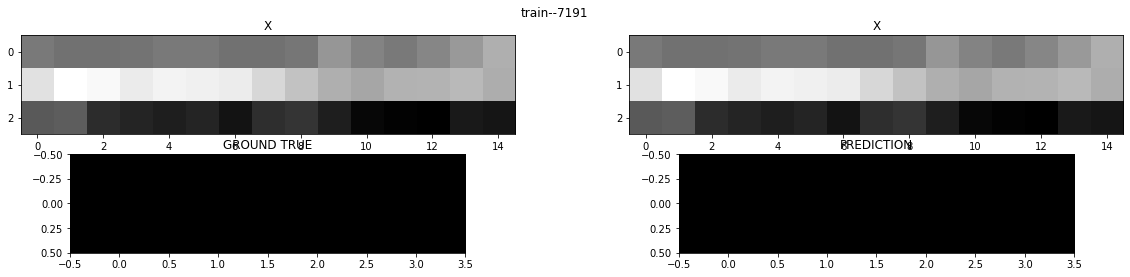

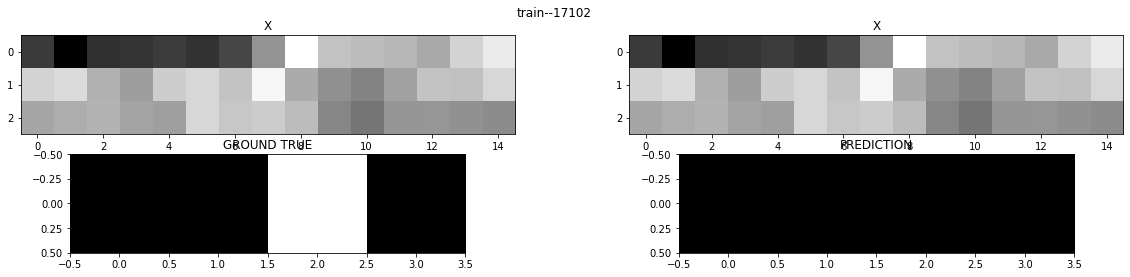

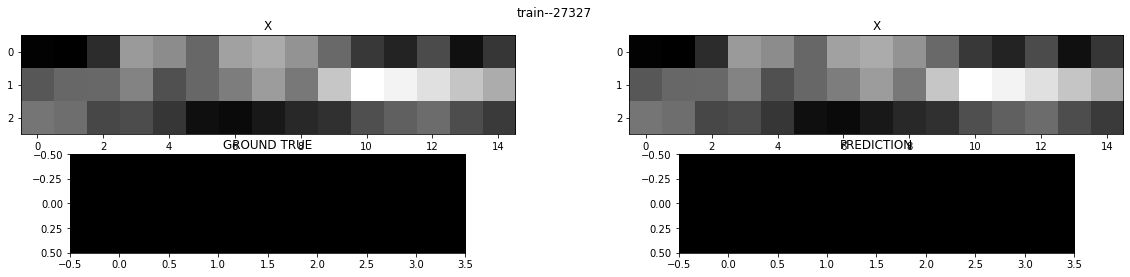

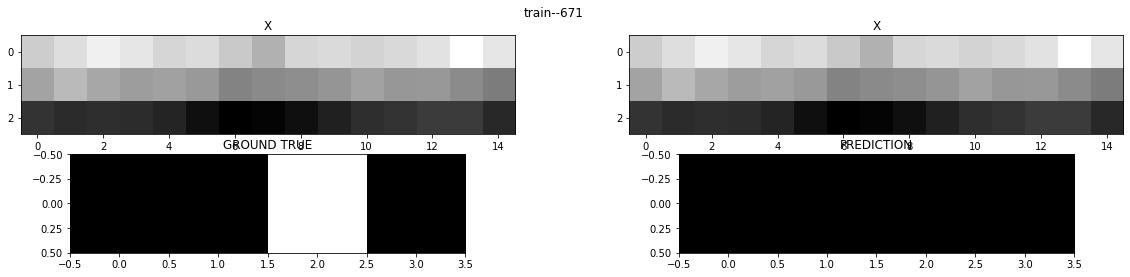

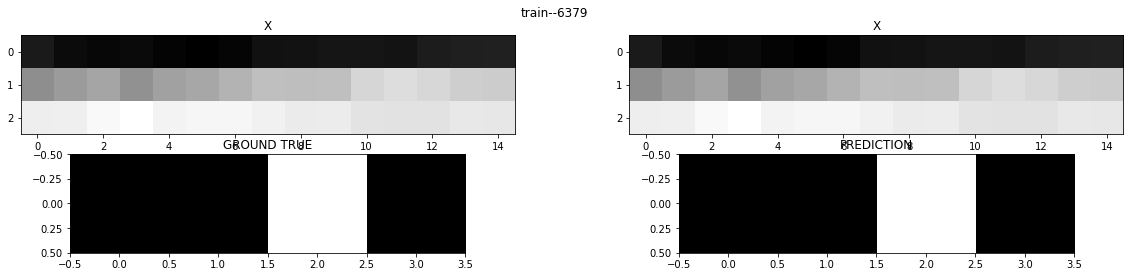

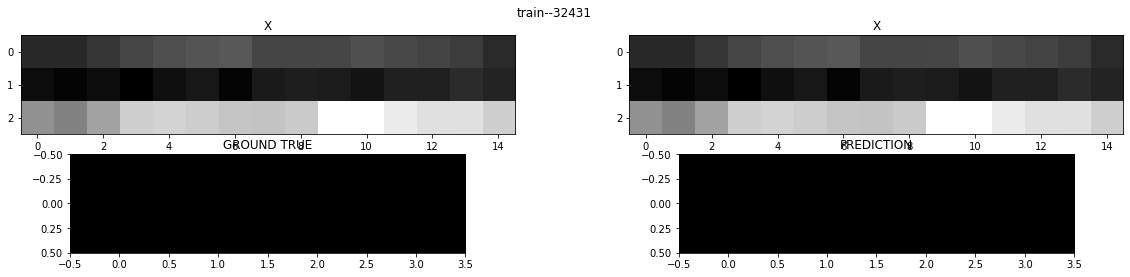

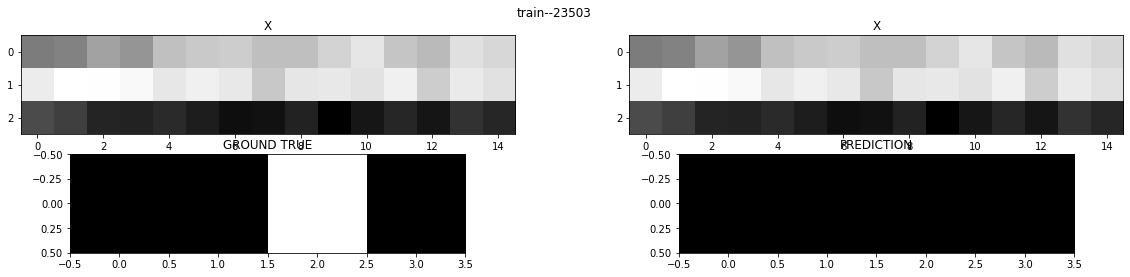

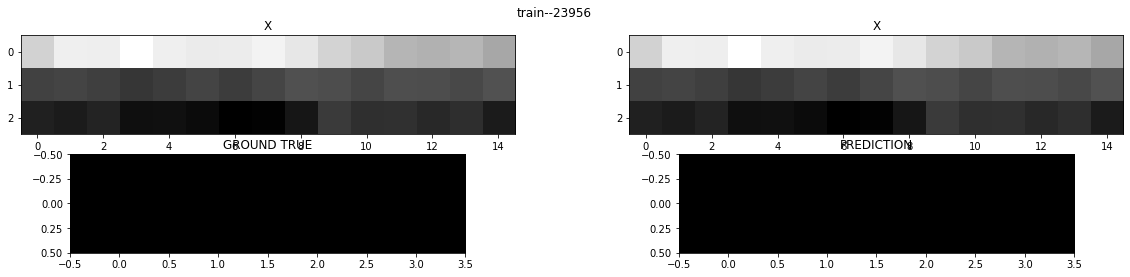

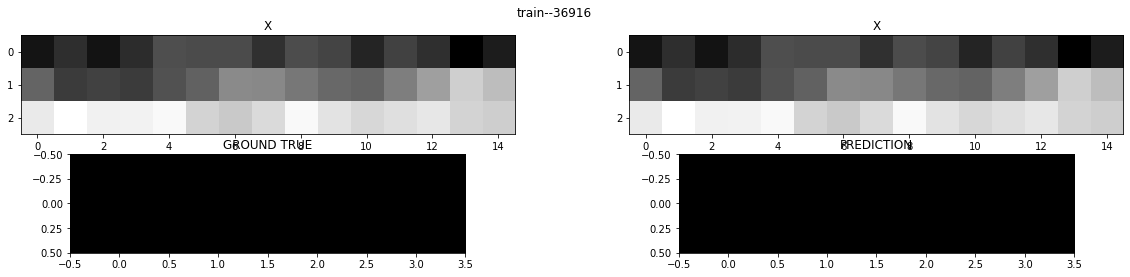

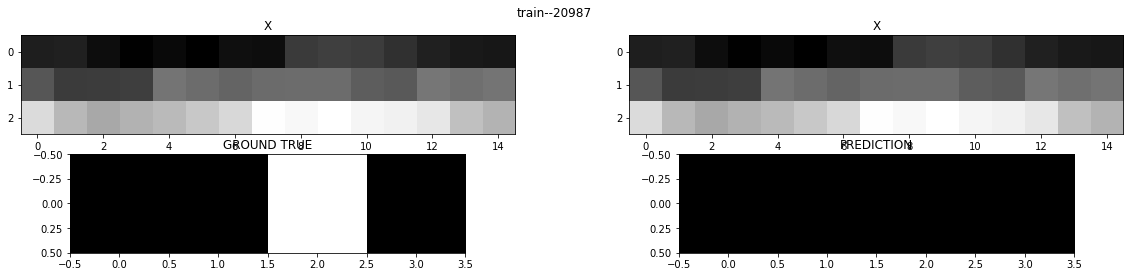

515/515 [==============================] - 1s 1ms/step


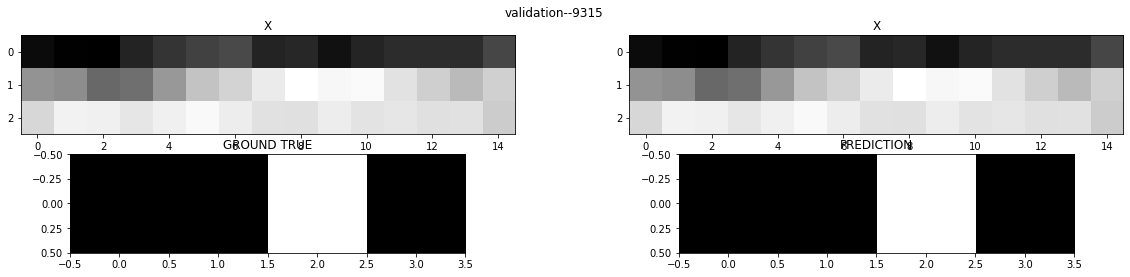

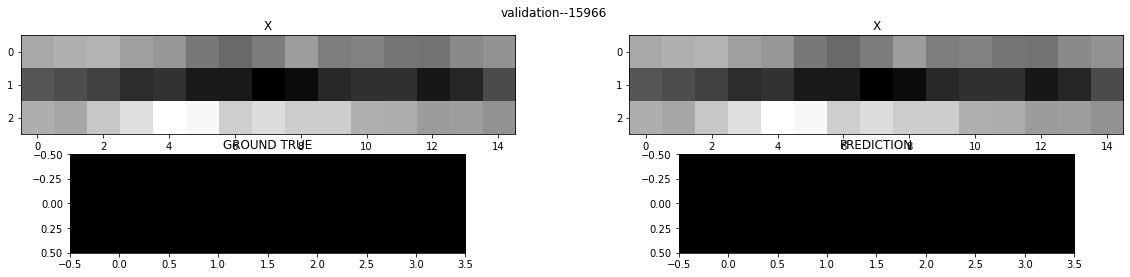

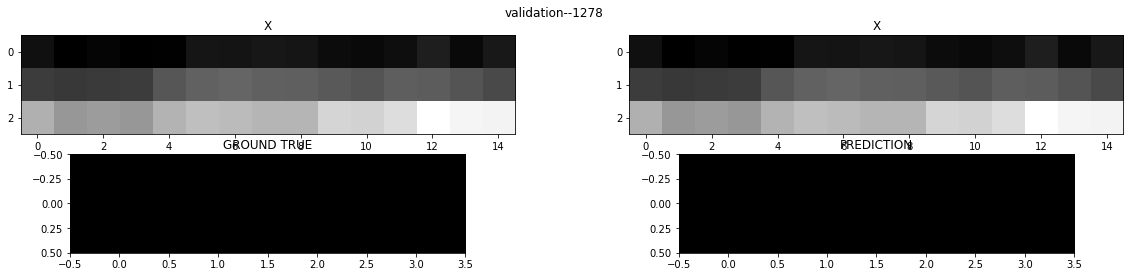

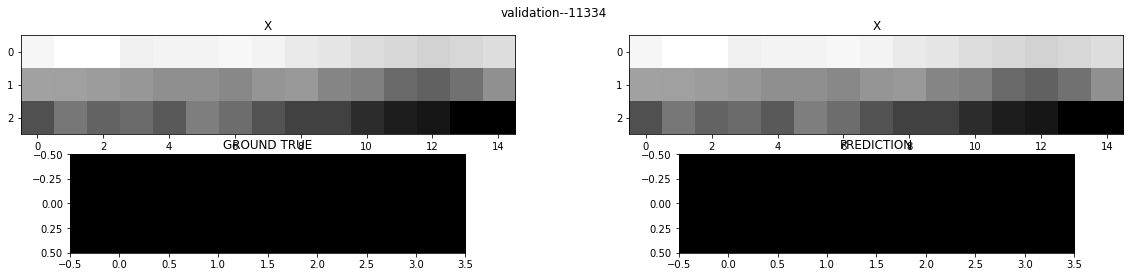

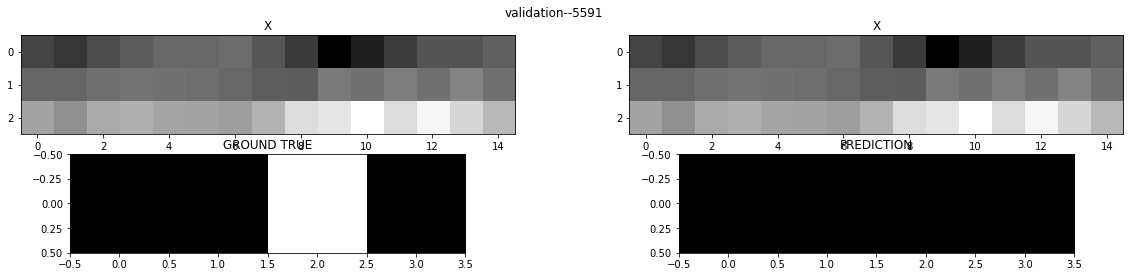

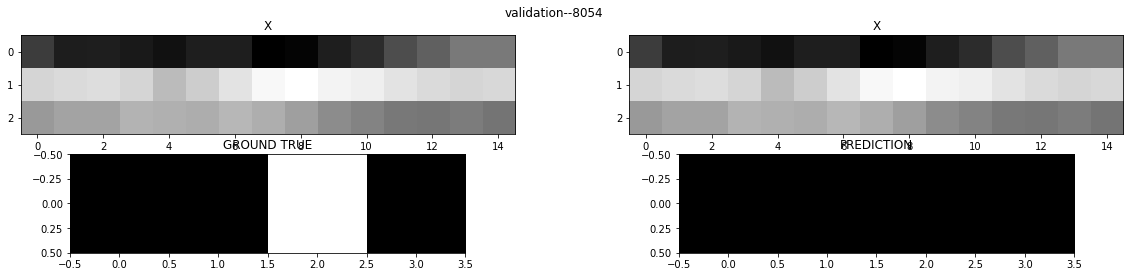

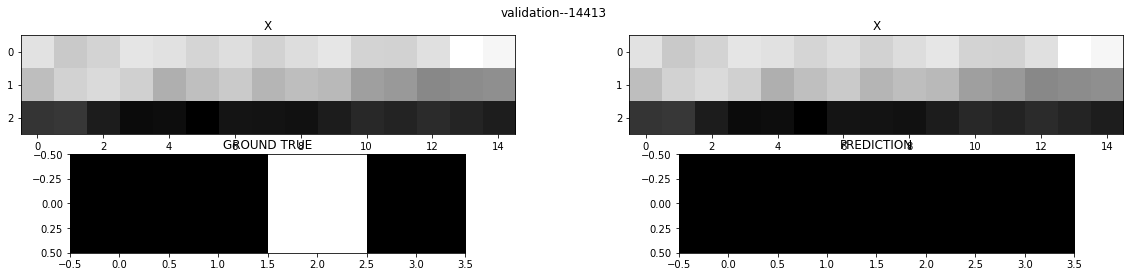

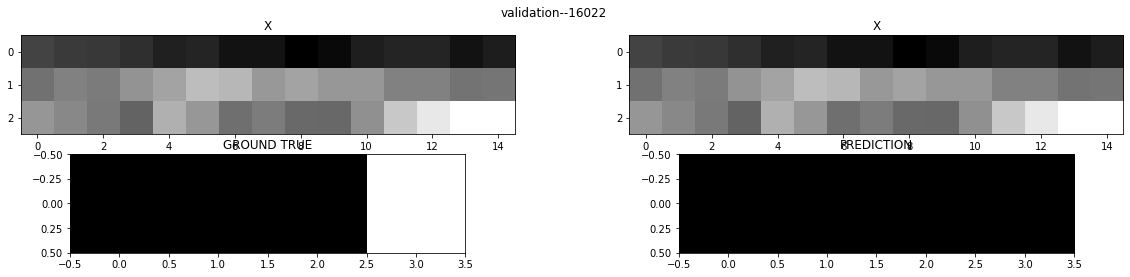

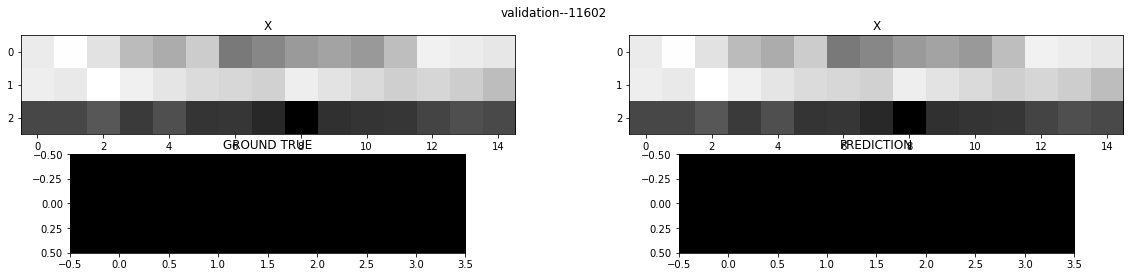

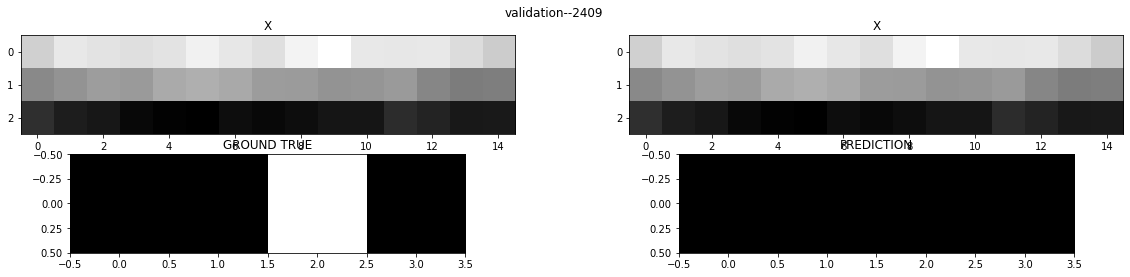

In [185]:
# sample results
for X_to_visualize,Y_to_visualize, sLabel in list(zip(a_X_datasets, a_Y_datasets, a_labels)):
    pred = oModel.predict(X_to_visualize)
    pred[pred >= 0.5] = 1
    pred[pred < 0.5] = 0
    ground_true = Y_to_visualize
    for i in np.random.randint(low = 0,high = len(X_to_visualize), size = 10):      
        
        fig, axs = plt.subplots(2,2, figsize=(20, 4))
        fig.suptitle('{}--{}'.format(sLabel, i))
        
        axs[0, 0].imshow(X_to_visualize[i], cmap='gray')
        axs[0, 0].set_title('X')

        axs[0, 1].imshow(X_to_visualize[i], cmap='gray')
        axs[0, 1].set_title('X')

                
        axs[1, 0].imshow(ground_true[[i]], cmap='gray')
        axs[1, 0].set_title( 'GROUND TRUE')

        axs[1, 1].imshow(pred[[i]], cmap='gray')
        axs[1, 1].set_title( 'PREDICTION')

        plt.show()

In [186]:
# classification report
for X_to_visualize,Y_to_visualize, sLabel in list(zip(a_X_datasets, a_Y_datasets, a_labels)):
    pred = oModel.predict(X_to_visualize)
    pred[pred >= 0.5] = 1
    pred[pred < 0.5] = 0
    ground_true = Y_to_visualize
    print(sLabel)
    print(classification_report(ground_true, pred, zero_division = 0))

1286/1286 [==============================] - 1s 1ms/step
train
              precision    recall  f1-score   support

           0       0.84      0.07      0.14       730
           1       0.86      0.15      0.25       124
           2       0.65      0.27      0.38     14395
           3       0.96      0.02      0.04      2384

   micro avg       0.66      0.23      0.34     17633
   macro avg       0.83      0.13      0.20     17633
weighted avg       0.70      0.23      0.32     17633
 samples avg       0.10      0.10      0.10     17633

515/515 [==============================] - 1s 1ms/step
validation
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       164
           1       0.00      0.00      0.00        32
           2       0.51      0.21      0.30      6540
           3       0.05      0.00      0.00       838

   micro avg       0.50      0.18      0.27      7574
   macro avg       0.14      0.05      0.08      7574
we

1286/1286 [==============================] - 1s 1ms/step


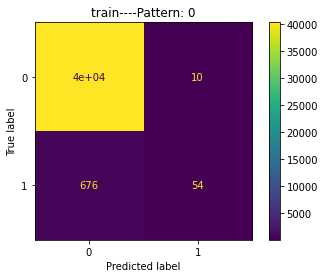

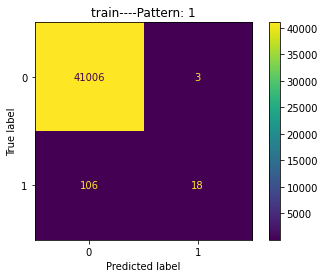

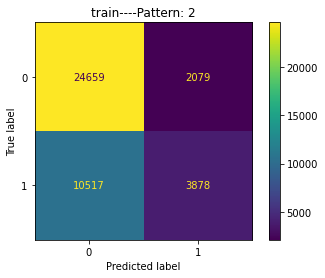

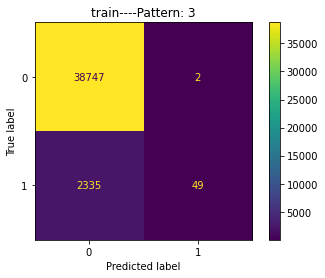

515/515 [==============================] - 1s 1ms/step


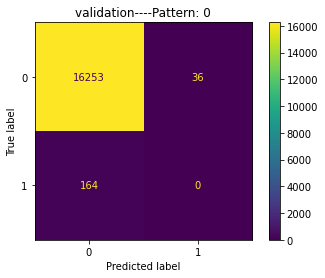

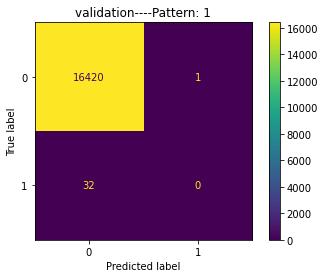

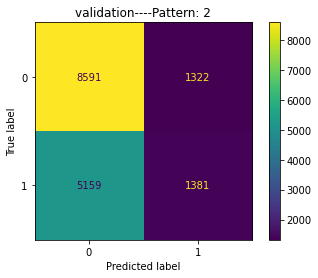

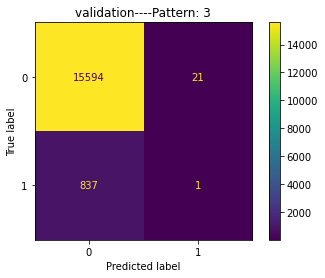

In [187]:
# confusion matrix
for X_to_visualize,Y_to_visualize, sLabel in list(zip(a_X_datasets, a_Y_datasets, a_labels)):
    pred = oModel.predict(X_to_visualize)
    pred[pred >= 0.5] = 1
    pred[pred < 0.5] = 0
    ground_true = Y_to_visualize

    for i in range(NR_OF_PATTERNS):
        oCm = confusion_matrix(ground_true[:, i], pred[:, i])
        oFig = ConfusionMatrixDisplay(confusion_matrix=oCm)
        oFig.plot()
        oFig.ax_.set_title('{}----Pattern: {}'.format(sLabel,i))
        plt.show()